# Enhancing the Chatbot with Tools

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

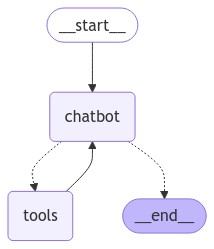

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://www.bbc.co.uk/news/articles/ceklk794102o", "content": "Tsai Ing-wen celebrates after winning Taiwan's 2016 presidential election. What she does want to emphasise is the perception of a growing China threat."}, {"url": "https://www.cnn.com/2024/05/18/asia/tsai-taiwan-map-china-intl-hnk-dst/index.html", "content": "Taiwan President Tsai Ing-wen waves to the crowd during her inauguration in May 2016 following her first presidential election win. Ashley Pon/Getty Images. Tsai Ing-wen: the leader who put Taiwan"}]
Assistant: Tsai Ing-Wen is an important figure in Taiwan as she is the current President of Taiwan. She first won the presidential election in 2016 and was re-elected in subsequent elections. Tsai Ing-Wen is known for her leadership and stance on issues, particularly concerning Taiwan's relationship with China. She has emphasized the perception of a growing China threat and has been instrumental in shaping Taiwan's foreign policy.
Goodbye!
